### Logistic Regression Task

#### Objective:
Perform binary classification of a dataset to predict the 10-year risk of coronary heart disease (CHD) into two classes:
- Having risk (1)
- Not having risk (0)

#### Dataset Details:

**1. Demographic:**
- **Sex:** Male or Female
- **Age:** Age of the patient
- **Education:** No further information provided

**2. Behavioral:**
- **Current Smoker:** Whether or not the patient is a current smoker
- **Cigs Per Day:** The number of cigarettes that the person smoked on average per day

**3. Information on Medical History:**
- **BP Meds:** Whether or not the patient was on blood pressure medication
- **Prevalent Stroke:** Whether or not the patient had previously had a stroke
- **Prevalent Hyp:** Whether or not the patient was hypertensive
- **Diabetes:** Whether or not the patient had diabetes

**4. Information on Current Medical Condition:**
- **Tot Chol:** Total cholesterol level
- **Sys BP:** Systolic blood pressure
- **Dia BP:** Diastolic blood pressure
- **BMI:** Body Mass Index
- **Heart Rate:** Heart rate (considered continuous in medical research)
- **Glucose:** Glucose level

**Target Variable:**
- **10-year Risk of Coronary Heart Disease (CHD):** Binary classification (1 = Yes, 0 = No)

#### Tasks:
1. Use Logistic Regression to classify the risk of coronary heart disease based on the provided attributes.
2. Evaluate the model's accuracy using appropriate evaluation metrics.
eans “Yes”, “0” means “No”)

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import math
import itertools

### Reading the data
We read the csv file into a pandas dataframe.

In [15]:
filepath = 'framingham.csv'

df = pd.read_csv(filepath)

### Explore the data
We explore the first few rows of the dataset and describe it

In [18]:
print("First few rows of the dataset:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

print("\nData types of each column:")
print(df.dtypes)

First few rows of the dataset:
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0  

### Handling missing data
1. Option 1: Fill missing values with a specific value (e.g., mean)
2. Option 2: Drop rows/columns with missing values

In [21]:
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

if missing_values.sum() > 0:
    df.fillna(df.mean(), inplace=True)
    print("\nMissing values were found and have been filled with the mean of each column.")

    #df.dropna(inplace=True)
    #print("\nMissing values were found and have been dropped.")
    
    print("\nMissing values after handling:")
    print(df.isnull().sum())
else:
    print("\nNo missing values found in the dataset.")


Missing values in each column:
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Missing values were found and have been filled with the mean of each column.

Missing values after handling:
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


### Defining Features and Targets
We create 2 numpy arrays $X$ and $y$ from the dataframe:
+ $X$: Input data of the shape (number of samples, number of input features)
+ $y$: Target variable of the shape (number of samples,)

In [24]:
X = df.drop(columns=['TenYearCHD']).values
y = df['TenYearCHD'].values

print("Shape of X: ", X.shape, ", Shape of y: ", y.shape)

Shape of X:  (4240, 15) , Shape of y:  (4240,)


### Splitting the Data
We pre-process the data using min-max scaler to scale the input data $X$.
After that, we split the data into a training dataset (**X_train** and **y_train**) and test dataset (**X_test and y_test**)

In [27]:
import numpy as np
def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)

    return X_scaled

X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X_train: ",X_train.shape, "Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape, "Shape of y_test: ",y_test.shape)

Shape of X_train:  (3180, 15) Shape of y_train:  (3180,)
Shape of X_test:  (1060, 15) Shape of y_test:  (1060,)


### Creating the Sigmoid Function
For logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$


The function below returns the value of the sigmoid function for an input numpy array z. If the numpy array 'z' stores multiple numbers, we'd like to apply the sigmoid function to each value in the input array

In [30]:
def sigmoid(z):
    z = z.astype(float)
    g = 1 / (1 + np.exp(-z))

    return g

### Computing the loss Function

For logistic regression, the cost function is of the form

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.

Here,

 **X**: input features

 **y**:  class labels

 **w**: Parameters of the logistic regression model, (excluding the bias), a numpy array of the shape(1, number of features)

 **b**:  Bias value of the logistic regression model

We use the Sigmoid function implemented above.

In [33]:
def loss_function(X, y, w, b):
    m, n = X.shape

    total_cost = 0
    for i in range(m):
        z = np.dot(X[i], w) + b
        val = sigmoid(z)
        total_cost += (-y[i] * np.log(val)) - ((1 - y[i]) * np.log(1 - val))

    total_cost /= m

    return total_cost

### 2.4. Computing the Gradient of the Loss

The gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

The `compute_gradient_logistic_regression` function computes $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label

In [36]:
def compute_gradient_logistic_regression(X, y, w, b):
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.0

    for i in range(m):
        z = np.dot(X[i], w) + b
        diff = sigmoid(z) - y[i]
        for j in range(n):
            dj_dw[j] += diff * X[i, j]
        dj_db += diff

    dj_dw /= m
    dj_db /= m

    return dj_db, dj_dw

### Training the model using Batch Gradient Descent

The batch gradient descent algorithm for logistic regression trains and learns the parameters of the logistic regression model. We use ```loss_function``` and ```compute_gradient_logistic regression``` functions that we implemented above.

In this ```batch_gradient_descent_logistic_regression``` function, we compute the gradient for the training samples and update the parameters $w$ and $b$ in every iteration:

+ $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

+ $b \leftarrow b - \alpha \frac{\partial L}{\partial b}$

Additionally, we compute the loss function values in every iteration and store it in the list variable ```loss_hist``` and print the loss value after every 100 iterations during the training process.

In [39]:
def batch_gradient_descent_logistic_regression(X, y, w_in, b_in, alpha, num_iters):
    m = len(X)
    loss_hist = []

    for i in range(1, num_iters + 1):
        dj_db, dj_dw = compute_gradient_logistic_regression(X, y, w_in, b_in)
        
        w_in -= alpha * dj_dw
        b_in -= alpha * dj_db
        
        loss = loss_function(X, y, w_in, b_in)
        loss_hist.append(loss)

        if (i % 100 == 0):
            print(f"Iteration: {i} Loss: {loss}")
    
    return w_in, b_in, loss_hist

### Initialising parameters
Now we intialize the model parameters ($w$ and $b$) and learning rate (**alpha**). The learning rate **alpha** is randomly initialized between 0.01 and 0.09. To randomly initialize the learning rate, we set a seed and use the random function.

In [42]:
random_seed = 88
np.random.seed(random_seed)

def initialize_parameters():
    initial_w = np.random.random((X_train.shape[1], ))
    initial_b = random.random()
    alpha = random.uniform(0.01, 0.09)

    return initial_w,initial_b,alpha

### Running the batch gradient descent
We run the batch gradient algorithm for num_iterations=1000 to train the logistic regression model. 

In [45]:
initial_w, initial_b, alpha = initialize_parameters()
num_iterations = 1000

w, b, loss_hist = batch_gradient_descent_logistic_regression(X_train ,y_train, initial_w, initial_b, alpha, num_iterations)
print("optimized parameter values w:", w)
print("optimized parameter value b:", b)

Iteration: 100 Loss: 0.43243110592938266
Iteration: 200 Loss: 0.4216821920733856
Iteration: 300 Loss: 0.4151635166679146
Iteration: 400 Loss: 0.41069085293669755
Iteration: 500 Loss: 0.4074856078250882
Iteration: 600 Loss: 0.40508410994176086
Iteration: 700 Loss: 0.4032070563278518
Iteration: 800 Loss: 0.4016833175882739
Iteration: 900 Loss: 0.4004059046838141
Iteration: 1000 Loss: 0.399306464504613
optimized parameter values w: [ 0.43444103  0.43770901 -0.3807142  -0.12965563  0.54143007  0.69451901
  0.76873969  0.60378392  0.3742499   0.01300535  0.75107484 -0.62972899
 -0.48552547  0.01258399  0.29746804]
optimized parameter value b: -2.091373453164426


### Final Train and Test Accuracy
After the logistic regression model is trained, we will predict the class labels for the training set and test set and we will compute the accuracy.

- First we to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example

- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, we use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [48]:
def predict(X, w, b):
      m, n = X.shape
      p = np.zeros(m)
    
      for i in range(m):
           prob_val = sigmoid(np.dot(X[i], w) + b)
           if prob_val >= 0.5 : 
               p[i] = 1
           else : 
               p[i] = 0

      return p

Now let's use this to compute the accuracy on the training and test datasets

In [51]:
p_train = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p_train == y_train) * 100))
p_test = predict(X_test, w,b)
print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))

Train Accuracy: 84.811321
Test Accuracy: 85.000000


### Evaluating the Model
We will plot the confusion matrix, calculate accuracy, precision, recall and F1-Score

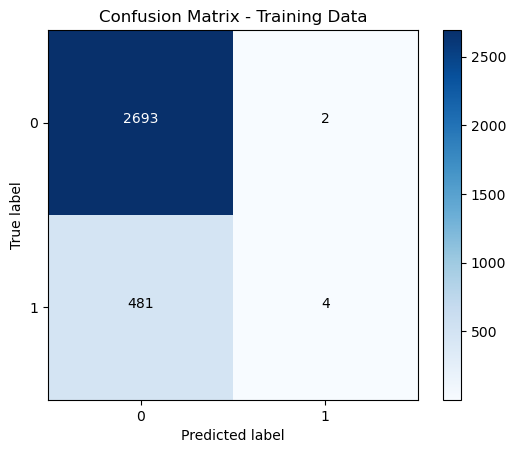

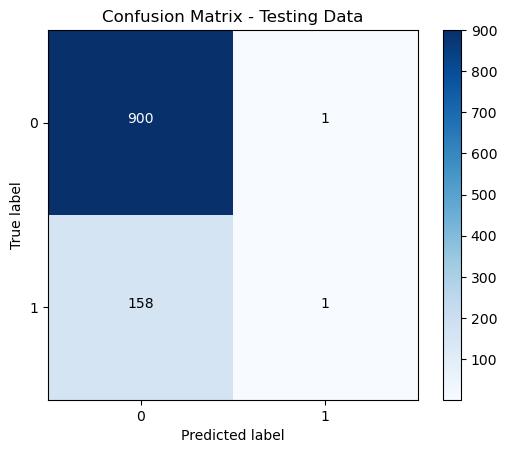

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm_train = confusion_matrix(y_train, p_train)
plot_confusion_matrix(cm_train, title='Confusion Matrix - Training Data')

cm_test = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm_test, title='Confusion Matrix - Testing Data')


In [62]:
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0

    return accuracy, precision, recall, f1_score

accuracy_train, precision_train, recall_train, f1_score_train = calculate_metrics(cm_train)
print(f"Training Data: Accuracy={accuracy_train*100:.2f}%, Precision={precision_train:.2f}, Recall={recall_train:.2f}, F1-Score={f1_score_train:.2f}")

accuracy_test, precision_test, recall_test, f1_score_test = calculate_metrics(cm_test)
print(f"Testing Data: Accuracy={accuracy_test*100:.2f}%, Precision={precision_test:.2f}, Recall={recall_test:.2f}, F1-Score={f1_score_test:.2f}")


Training Data: Accuracy=84.81%, Precision=0.67, Recall=0.01, F1-Score=0.02
Testing Data: Accuracy=85.00%, Precision=0.50, Recall=0.01, F1-Score=0.01
